# 사용자 행동 인식 예측 모델 실습
- 의사결정나무, 랜덤포레스트, GBM 모델을 사용
- 각 모델을 GridSearchCV를 이용한 하이퍼 파라미터 튜닝
-알려드린 것들을 대부분 써보시는게 좋을 듯...
- 최적의 성능을 낸 모델을 찾고, 각 모델의 특성 중요도 레포트 작성

# 실습 코드는 책 참고

In [52]:
DATA_PATH = "/Users/khb43/Desktop/HANKYUNG_WITH_TOSS_BANK(2)/week5_python_ machine_learning /실습/human_activity"

FEATURE_NAME_PATH  = DATA_PATH + "/features.txt"

TRAIN_FEATURE_PATH = DATA_PATH + "/train/X_train.txt"
TRAIN_LABEL_PATH   = DATA_PATH + "/train/y_train.txt"

TEST_FEATURE_PATH  = DATA_PATH + "/test/X_test.txt"
TEST_LABEL_PATH    = DATA_PATH + "/test/y_test.txt"

In [53]:
import pandas as pd

def get_human_dataset( ):

    def get_new_feature_name_df(old_feature_name_df):
        feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
        feature_dup_df = feature_dup_df.reset_index()
        new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
        new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] >0 else x[0],  axis=1)
        new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
        return new_feature_name_df

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(FEATURE_NAME_PATH, sep='\s+', header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(TRAIN_FEATURE_PATH,sep='\s+', names=feature_name )
    X_test = pd.read_csv(TEST_FEATURE_PATH,sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(TRAIN_LABEL_PATH,sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(TEST_LABEL_PATH,sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [54]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [55]:
X_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,0.116695,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.121711,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857


In [56]:
y_train.head()

,action
0,5
1,5
2,5
3,5
4,5


In [57]:
y_test.head()

,action
0,5
1,5
2,5
3,5
4,5


In [58]:
# train
print("X_train shape : {}".format(X_train.shape))
print("y_train shape :{}".format(y_train.shape))

print("\n")

# test
print("X_test shape : {}".format(X_test.shape))
print("y_test shape :{}".format(y_test.shape))


X_train shape : (7352, 561)
y_train shape :(7352, 1)


X_test shape : (2947, 561)
y_test shape :(2947, 1)


In [59]:
# 모델 훈련 시키기

#의사결정나무 분류기 사용
from sklearn.tree import DecisionTreeClassifier

# 모델 객체 생성 - 모델의 각종 옵션(하이퍼 파라미터)을 설정
happ_model = DecisionTreeClassifier()

# 모델 훈련 - 훈련이 다 끝나면, 학습된 모델이 Return 된다.
happ_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [60]:
# 테스트 데이터를 이용한 예측

pred = happ_model.predict(X_test)
print("테스트 세트의 예측 결과 : {}".format(pred))

테스트 세트의 예측 결과 : [5 5 5 ... 2 1 3]


In [61]:
from sklearn.metrics import accuracy_score

happ_result = accuracy_score(y_test, pred)
# print("예측 정확도 : {:.4f}".format(happ_result))

예측 정확도 : 0.8639


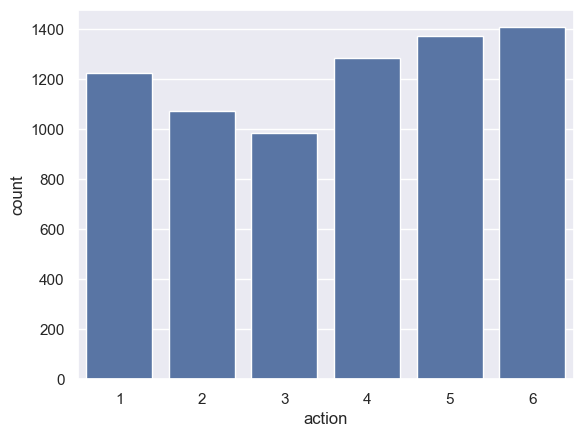

In [64]:
# 훈련 데이터의 라벨 분포 시각화 
# y_train 데이터의 각 라벨 값에 대한 개수를 세어 막대 그래프 
# 데이터셋에서 각 클래스(활동)가 얼마나 많이 포함되어 있는지 확인

import matplotlib.pyplot as plt
import seaborn as sns 

# 시각화 테마 설정
sns.set_theme()

# y_train이 DataFrame이라면 Series로 변환
y_train_series = y_train.squeeze()

# countplot 그리기
sns.countplot(x=y_train_series)
plt.show()


In [72]:
from sklearn.model_selection import KFold
import numpy as np

# 3개의 폴드 세트로 분리하는 KFold 객체 생성
kfold = KFold(n_splits=5)


# KFold 객체의 split() 함수를 호출하면 폴드 별 학습용, 검증용 테스트의 인덱스를 array로 반환
for train_indices, valid_indices in kfold.split(X_train):
    print("검증 세트의 인덱스 : {}".format(valid_indices))
    print("훈련 세트의 인덱스 : {}".format(train_indices))
    print()

검증 세트의 인덱스 : [   0    1    2 ... 1027 1028 1029]
훈련 세트의 인덱스 : [1030 1031 1032 ... 5143 5144 5145]

검증 세트의 인덱스 : [1030 1031 1032 ... 2056 2057 2058]
훈련 세트의 인덱스 : [   0    1    2 ... 5143 5144 5145]

검증 세트의 인덱스 : [2059 2060 2061 ... 3085 3086 3087]
훈련 세트의 인덱스 : [   0    1    2 ... 5143 5144 5145]

검증 세트의 인덱스 : [3088 3089 3090 ... 4114 4115 4116]
훈련 세트의 인덱스 : [   0    1    2 ... 5143 5144 5145]

검증 세트의 인덱스 : [4117 4118 4119 ... 5143 5144 5145]
훈련 세트의 인덱스 : [   0    1    2 ... 4114 4115 4116]



In [76]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 데이터프레임을 numpy 배열로 변환
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().ravel()  # 1차원 배열로 변환

n_iter = 0
cv_accuracy = [] # 각 폴드에서의 정확도를 담을 배열

kfold = KFold(n_splits=5)

for train_indices, valid_indices in kfold.split(X_train_np):

    # 반환된 인덱스를 이용해 학습용, 검증용 데이터를 추출
    X_train_fold, X_valid_fold = X_train_np[train_indices], X_train_np[valid_indices]
    y_train_fold, y_valid_fold = y_train_np[train_indices], y_train_np[valid_indices]

    # 모델 생성 및 훈련
    dt_clf = DecisionTreeClassifier().fit(X_train_fold, y_train_fold) # 모델 객체 생성과 동시에 훈련

    # 예측
    pred = dt_clf.predict(X_valid_fold)

    # 평가
    acc = accuracy_score(y_valid_fold, pred)

    # 해당 폴드의 평가 결과를 배열에 저장
    cv_accuracy.append(acc)

    n_iter += 1
    print("{} 번째 폴드에 대한 평가 결과 : {:.4f}".format(n_iter, acc))

print()
print("최종 결과 : {:.4f}".format(np.mean(cv_accuracy)))


1 번째 폴드에 대한 평가 결과 : 0.9437
2 번째 폴드에 대한 평가 결과 : 0.9261
3 번째 폴드에 대한 평가 결과 : 0.9300
4 번째 폴드에 대한 평가 결과 : 0.9174
5 번째 폴드에 대한 평가 결과 : 0.9155

최종 결과 : 0.9265


In [78]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    DecisionTreeClassifier(), # Classifier가 들어가면 자동으로 Stratifed KFold를 사용.
    X_train,
    y_train,
    scoring='accuracy', # 성능 측정 방식. 여기서는 정확도를 사용
    cv=5 # 폴드의 개수
)

print("폴드 별 정확도 확인 : {}".format(scores))
print("평균 정확도 확인 : {}".format(np.mean(scores)))

폴드 별 정확도 확인 : [0.92912621 0.93002915 0.91642371 0.91156463 0.9154519 ]
평균 정확도 확인 : 0.9205191202694671


In [80]:
from sklearn.model_selection import GridSearchCV, KFold

# 하이퍼파라미터의 후보를 정의
params = {
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 의사결정나무 분류기 생성
dt_clf = DecisionTreeClassifier()

# GridSearchCV 객체 생성
grid_search = GridSearchCV(dt_clf, param_grid=params, cv=5, scoring='accuracy')

# 학습 데이터로 GridSearchCV 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 그에 따른 성능 확인
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 테스트 데이터에 대해 예측 수행
best_dt_clf = grid_search.best_estimator_
pred = best_dt_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, pred)
print("Test Set Accuracy: {:.4f}".format(test_accuracy))

Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.9289
Test Set Accuracy: 0.9338
